# Import library


In [1]:
# discard the output of this cell
%%capture

#install the required libraries
!pip install pafy youtube-dl moviepy


In [2]:
# import the required lib
import os
import cv2
import pafy
import random
import numpy as np
import datetime
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)



  if event.key is 'enter':



In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
# Discard the output of the cell
%%capture

# Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the dataset
!unrar x UCF50.rar



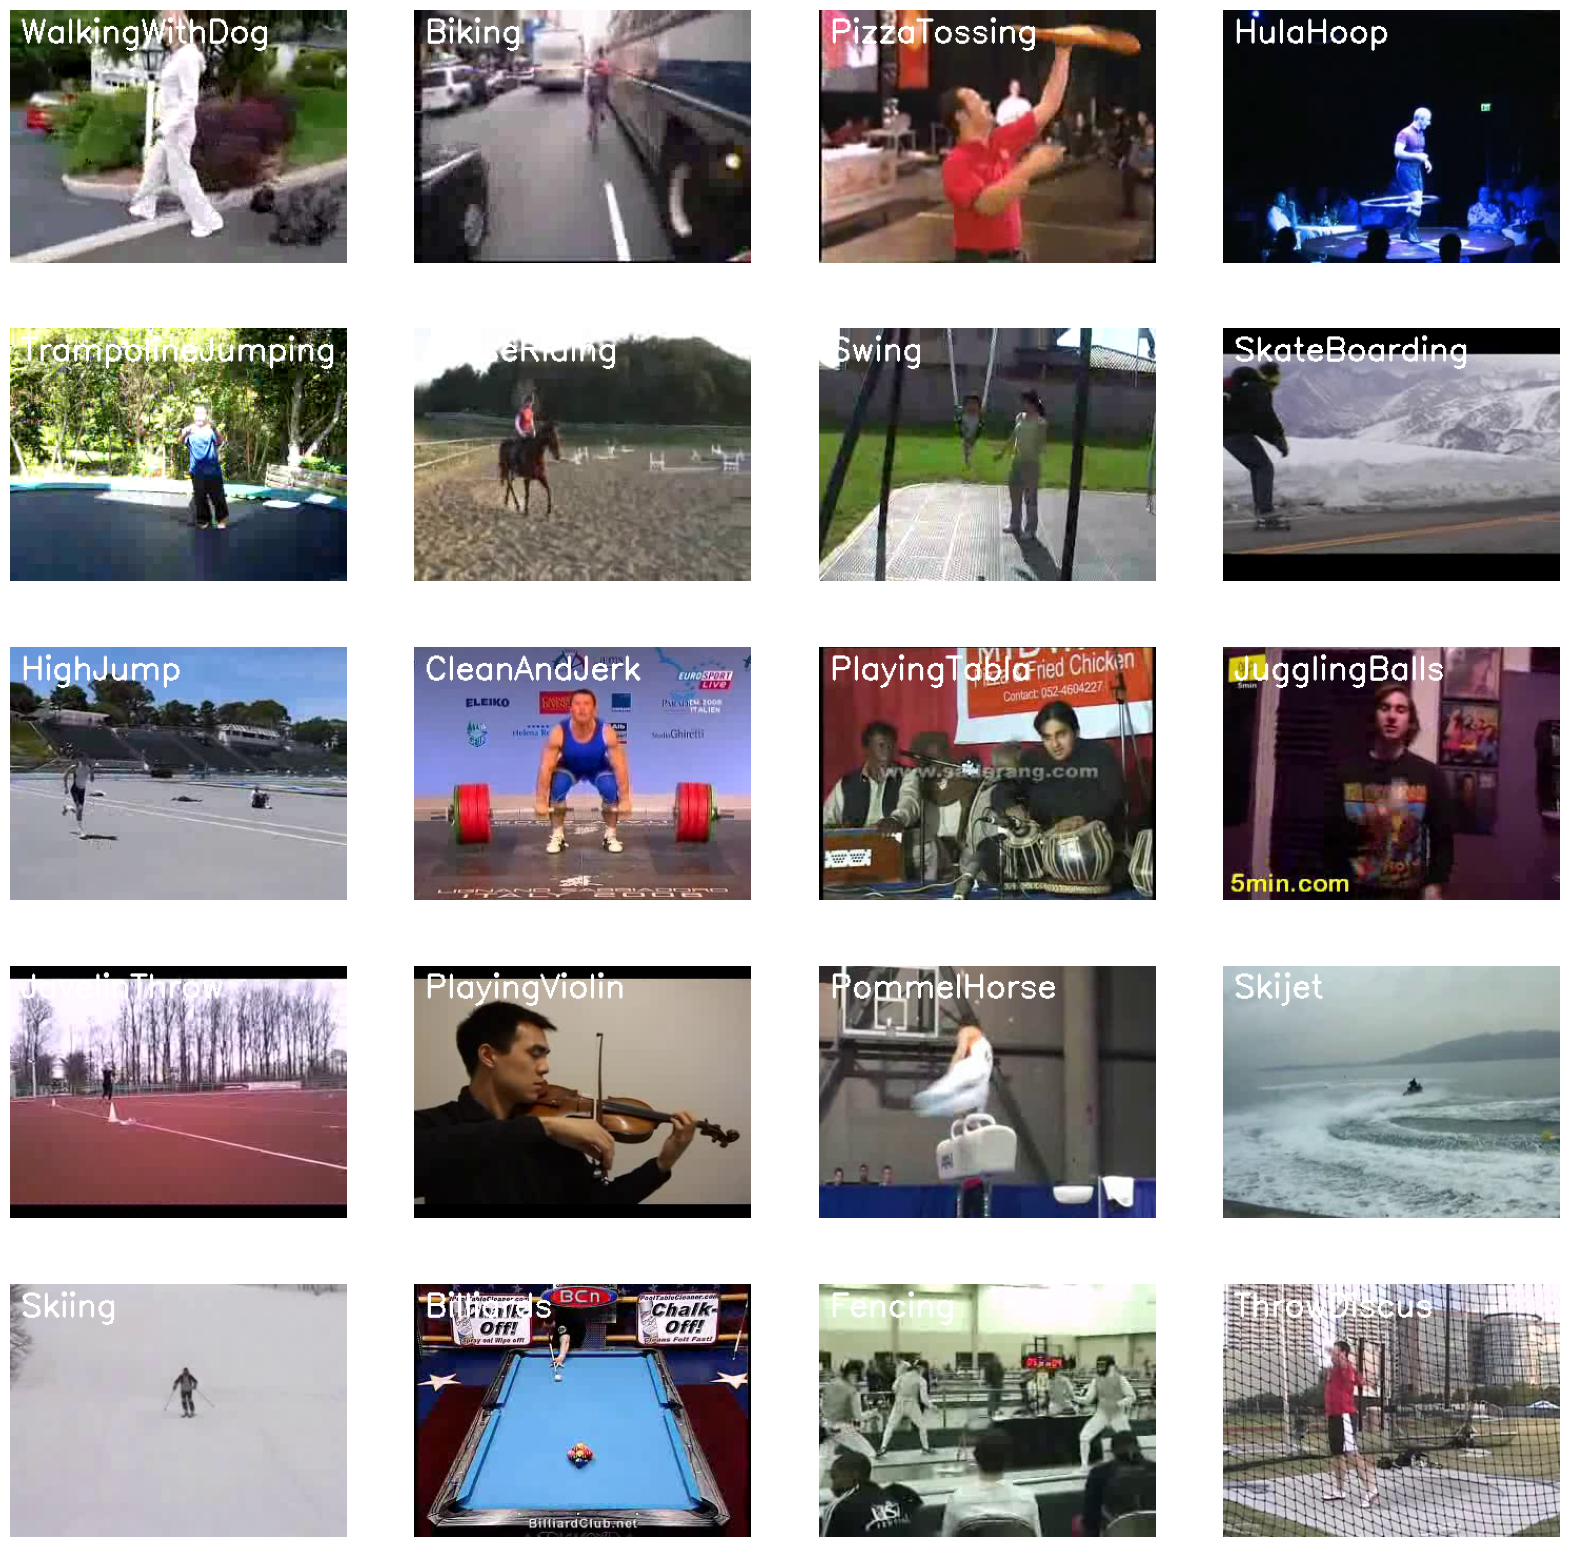

In [5]:
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50
all_classes_names = os.listdir('UCF50')


# Generate a list of 20 random values . The values will be between 0-50,
# where 50 is the total number of class in the dataset
random_range = random.sample(range(len(all_classes_names)),20)


# Iterating through all the generated random variables
for counter, random_index in enumerate(random_range, 1):

    # Getting a class name from the generated random index
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected class directory
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
    # Randomly select a video file from the list of all the video files present in the randomly selected class directory
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # Release the videocapture object
    video_reader.release()

    # Convert the frame from BGR into RGB format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


Preprocess the dataset

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset
IMG_HEIGHT, IMG_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset
DATASET_DIR = "UCF50"

# Specify the list containing the names of all classes/categories
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [7]:
def frames_extraction(video_path):
  # Declare a list to store video frames
  frames_list = []

  # Read the Video File using the VideoCapture object
  video_reader = cv2.VideoCapture(video_path)

  # Get the total number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the the interval after which frames will be added to the list
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Iterate through the video frames
  for frame_counter in range(SEQUENCE_LENGTH):

    # Set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Read a frame
    success, frame = video_reader.read()

    # Check if frame is not read properly then break the loop
    if not success:
      break
    # Resize the frame to fixed height and width
    resized_frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255

    # Append the normalized frame into the frames list
    frames_list.append(normalized_frame)

  # Release the VideoCapture object
  video_reader.release()

  # Return the frames list
  return frames_list



In [8]:
def create_dataset():


  # Declared Empty Lists to store the features , labels and video file path values.
  features = []
  labels = []
  video_files_paths = []

  # Iterating through all the classes mentioned in the class list
  for class_index, class_name in enumerate(CLASSES_LIST):
    # Dsiplay the name of the clas whoese data is being extracted
    print(f'Extracting Data of Class: {class_name}')

    # Getting the list of video files present in the specific class name directory
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    # Iterate through all the files present in the files list
    for file_name in files_list:
      # Get the complete video path
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      # Extract the frames of the video file
      frames = frames_extraction(video_file_path)

      # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above
      # So that all the videos have the same length of frames
      if len(frames)==SEQUENCE_LENGTH:

        # Append the data to their repective lists
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # Converting the list to numpy arrays
  features = np.asarray(features)
  labels = np.array(labels)

  # Return the frames , class index , and video file path
  return features, labels, video_files_paths


In [9]:
# Create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [10]:
# Using Keras to categorical method to convert labels into one hot encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# Split the data into train (75%) and test set(25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,test_size = 0.25, shuffle = True, random_state = seed_constant)

In [12]:
def create_convlstm_model():


  # We will use a sequential model for model construction
  model = Sequential()

  # Define the model architecture
  model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences= True, input_shape = (SEQUENCE_LENGTH, IMG_HEIGHT,
                                                                                     IMG_WIDTH, 3)))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 256, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  #model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  # Display the models summary
  model.summary()

  # Return the constructed model
  return model

In [13]:
# Construct the required convlstm model
convlstm_model = create_convlstm_model()

# Display the sucess message
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 64) │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29,     │       885,248 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13,     │     3,539,968 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 250880)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │     1,003,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,583,364 (21.30 MB)

 Trainable params: 5,583,364 (21.30 MB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


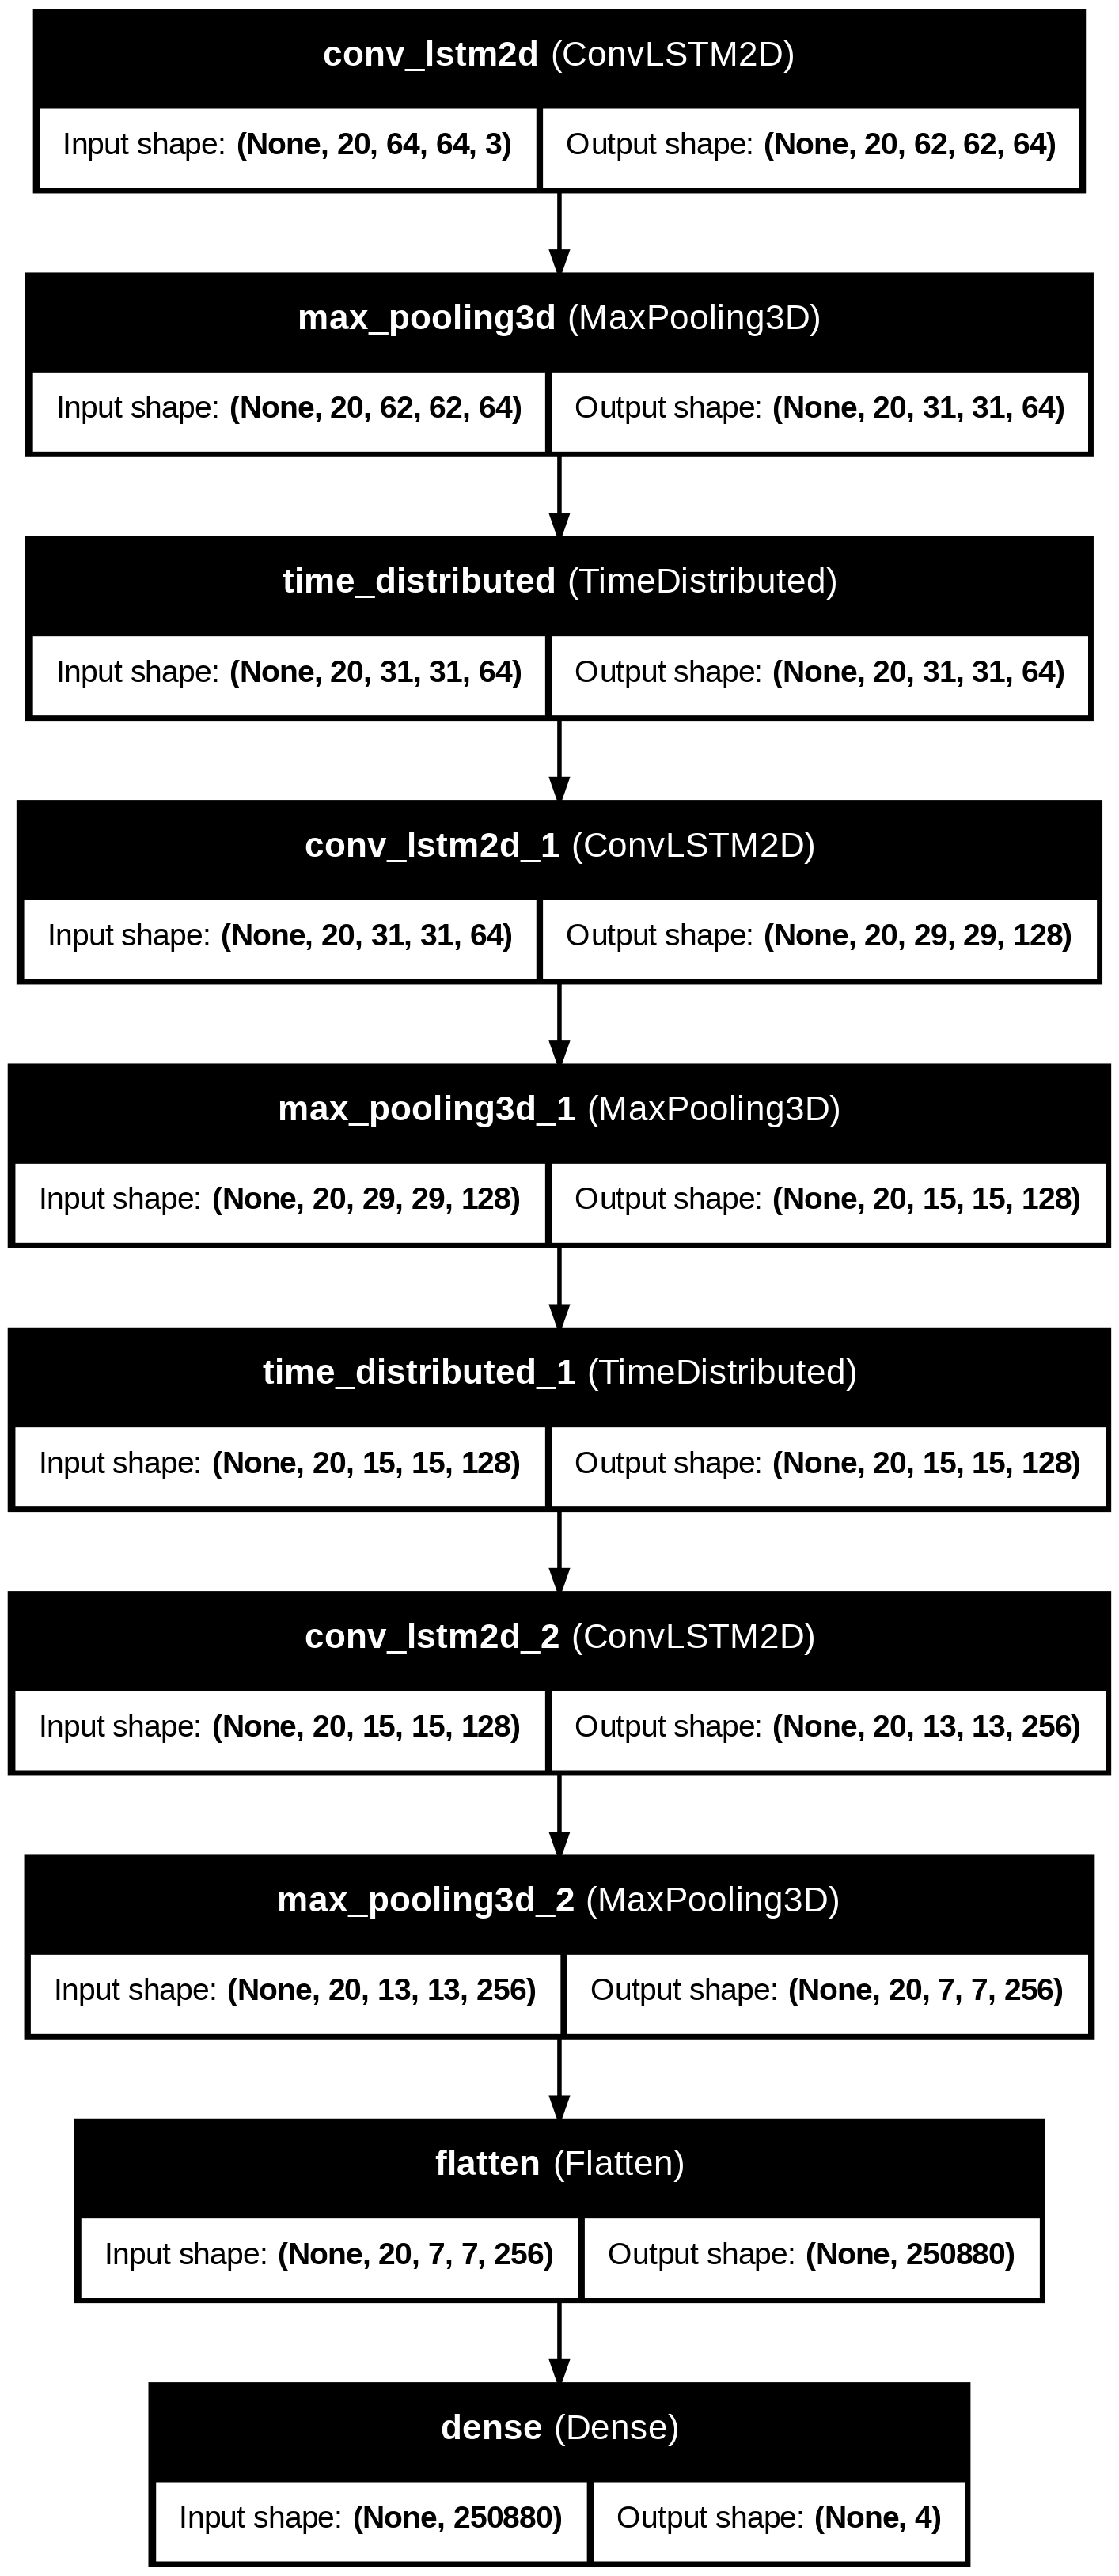

In [14]:
# Plot the structure of the constructed model
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)


In [15]:
# Create an instance of early stopping callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start trainig model
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 ,shuffle = True, validation_split = 0.2, callbacks =
                                                     [early_stopping_callback])


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 72s 413ms/step - accuracy: 0.3024 - loss: 2.4300 - val_accuracy: 0.6027 - val_loss: 0.9963
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 354ms/step - accuracy: 0.4733 - loss: 1.2298 - val_accuracy: 0.6575 - val_loss: 0.9019
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 372ms/step - accuracy: 0.6447 - loss: 0.8482 - val_accuracy: 0.6438 - val_loss: 1.0448
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 365ms/step - accuracy: 0.7421 - loss: 0.6039 - val_accuracy: 0.7260 - val_loss: 0.7445
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 372ms/step - accuracy: 0.8082 - loss: 0.5281 - val_accuracy: 0.6986 - val_loss: 1.1120
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.7882 - loss: 0.5216 - val_accuracy: 0.7671 - val_loss: 0.8175
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 357ms/step - accuracy: 0.9040 - loss: 0.2905 - val_accuracy: 0.7671 - val_loss: 0.9603
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 354ms/step - accuracy: 0.9199 - loss: 0.2115 - val_accu

In [16]:
# Evaluate the trained model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7114 - loss: 0.7642


In [17]:
import datetime
# Get the loss and accuracy from model evaluation_hsitory
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format
# Get the current Date and Time in a Datetime object
# Convert the Datetime object to string according to the style mentioned in date_time_format string
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = datetime.datetime.now()
current_date_time_string = str(current_date_time_dt.strftime(date_time_format))

# Define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your model
convlstm_model.save(model_file_name)

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  # Get metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Construct a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plot the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Add title to the plot
  plt.title(str(plot_name))

  # Add legend to the plot
  plt.legend()

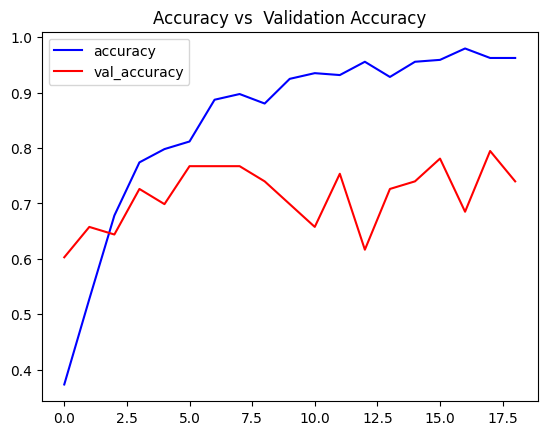

In [20]:
# Visualize the training and validation loss metrics
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Accuracy vs  Validation Accuracy')

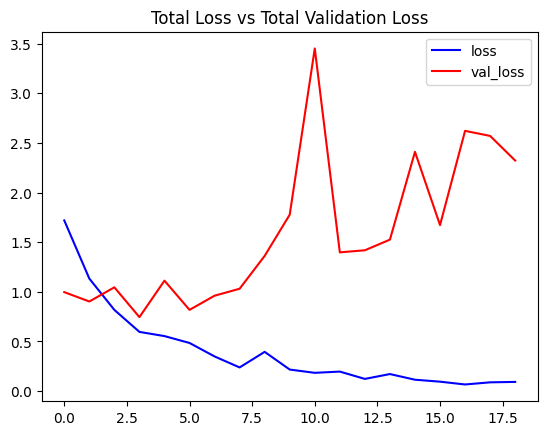

In [21]:
# Visualize the training and validation loss metrics
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')